In [88]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 증시예측

- 데이터 유효성, 누락 검사
- 분포, 상관관계 분석
- 전처리 : 이동평균, x(하루전?) y(다음날종가? 거래량?) 분리, 정규화
- LinearRegression 점수 측정, tensorflow 뉴럴 네트워크로 점수 측정
- 그래프로 시각화 (역정규화한 예측)

In [89]:
url = 'https://finance.naver.com/item/sise_day.nhn?code=024950&page='
tables = pd.read_html(url)
len(tables)

2

In [90]:
page_list = []
for page in range(1, 51):
    tables = pd.read_html(url+str(page))
    page_list.append(tables[0])
len(page_list)    

50

In [94]:
df = pd.concat(page_list, axis=0)
df = df.dropna()
df = df.set_index('날짜').drop(columns='전일비')
df = df[::-1]
df.shape

(500, 5)

In [114]:
df.head()

,종가,시가,고가,저가,거래량
날짜,,,,,
2017.08.24,10200.0,10050.0,10200.0,10050.0,17484.0
2017.08.25,10600.0,10200.0,10700.0,10200.0,77514.0
2017.08.28,10500.0,10800.0,10800.0,10450.0,26052.0
2017.08.29,10300.0,10400.0,10500.0,10150.0,41579.0
2017.08.30,10400.0,10300.0,10500.0,10200.0,16444.0


In [96]:
df = df.dropna()

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 2017.08.24 to 2019.09.10
Data columns (total 5 columns):
종가     500 non-null float64
시가     500 non-null float64
고가     500 non-null float64
저가     500 non-null float64
거래량    500 non-null float64
dtypes: float64(5)
memory usage: 23.4+ KB


In [98]:
df.corr()

,종가,시가,고가,저가,거래량
종가,1.000000,0.992247,0.992944,0.996090,0.017560
시가,0.992247,1.000000,0.988646,0.997041,-0.023791
고가,0.992944,0.988646,1.000000,0.988943,0.056647
저가,0.996090,0.997041,0.988943,1.000000,-0.028747
거래량,0.017560,-0.023791,0.056647,-0.028747,1.000000


In [99]:
df.head()

,종가,시가,고가,저가,거래량
날짜,,,,,
2017.08.24,10200.0,10050.0,10200.0,10050.0,17484.0
2017.08.25,10600.0,10200.0,10700.0,10200.0,77514.0
2017.08.28,10500.0,10800.0,10800.0,10450.0,26052.0
2017.08.29,10300.0,10400.0,10500.0,10150.0,41579.0
2017.08.30,10400.0,10300.0,10500.0,10200.0,16444.0


In [100]:
df.shape

(500, 5)

In [101]:
x = df.iloc[:-1]
y = df.iloc[1:]['종가']

In [102]:
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32).reshape([-1, 1])
x.shape, y.shape, np.min(y), np.max(y)

((499, 5), (499, 1), 5470.0, 11000.0)

In [103]:
# sklearn으로 정규화
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [104]:
scaler_x = MinMaxScaler().fit(x)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(x)
yn = scaler_y.transform(y)
np.min(xn), np.max(xn), np.min(yn), np.max(yn)

(0.0, 1.0000001, 0.0, 1.0)

In [105]:
w1 = tf.Variable(tf.random_normal(shape=[5, 2])) ## x > hidden 784=28*28
b1 = tf.Variable(tf.random_normal(shape=[2]))
w2 = tf.Variable(tf.random_normal(shape=[2, 1])) ## hidden > h 
b2 = tf.Variable(tf.random_normal(shape=[1])) # 이진분류라서 1이라 했지만, 다중분류이면 k개 설정
## xn = x / tf.reduce_max(xn, -1, True)
h1 = tf.sigmoid(tf.matmul(xn, w1)+b1)
out = tf.matmul(h1, w2)+b2
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(y, tf.int64), tf.arg_max(out, -1)), tf.float32))
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [106]:
for i in range(1000):
    _, c, = sess.run([train, cost])
    if(i%100)==0: print(i, c, r2_score(yn, sess.run(out)))


0 0.9795624 -8.461770542585464
100 0.0029101672 0.9563017401458148
200 0.0024367142 0.9633801222430697
300 0.0021920672 0.9670374567092042
400 0.0020647391 0.968941481273712
500 0.001995361 0.9699795845463747
600 0.0019545748 0.9705904002499285
700 0.001928159 0.9709864231837971
800 0.0019091741 0.9712713226361089
900 0.0018941766 0.9714965917211476


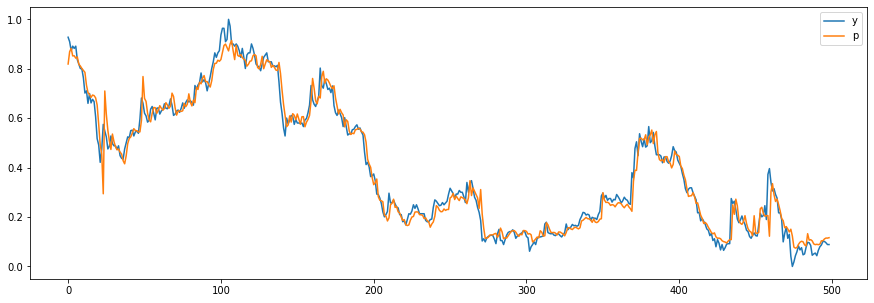

In [107]:
plt.figure(figsize=(15, 5))
plt.plot(yn, label='y')
plt.plot(sess.run(out), label='p')
plt.legend()

In [118]:
# 전일비 칼럼 추가
# 전일비 - 증가 - 다음날 시가
전일비 = df.iloc[:-1]['종가'] - df.iloc[1:]['시가']
전일비.head()

날짜
2017.08.24      NaN
2017.08.25    400.0
2017.08.28   -300.0
2017.08.29   -100.0
2017.08.30    100.0
dtype: float64

이동 평균 넣어보자

In [109]:
df_roll = df.rolling(window=5).mean()
df_roll.head(10)

,종가,시가,고가,저가,거래량
날짜,,,,,
2017.08.24,NaN,NaN,NaN,NaN,NaN
2017.08.25,NaN,NaN,NaN,NaN,NaN
2017.08.28,NaN,NaN,NaN,NaN,NaN
2017.08.29,NaN,NaN,NaN,NaN,NaN
2017.08.30,10400.0,10350.0,10540.0,10210.0,35814.6
2017.08.31,10430.0,10390.0,10580.0,10250.0,34072.4
2017.09.01,10390.0,10410.0,10530.0,10250.0,23138.2
2017.09.04,10310.0,10280.0,10410.0,10160.0,26523.2
2017.09.05,10250.0,10210.0,10340.0,10130.0,25916.0


In [110]:
df_roll.columns = ['종가r', '시가r', '고가r', '저가r', '거래량r']

In [111]:
df_con = pd.concat((df, df_roll), axis=1 ).dropna()
df_con.head()

,종가,시가,고가,저가,거래량,종가r,시가r,고가r,저가r,거래량r
날짜,,,,,,,,,,
2017.08.30,10400.0,10300.0,10500.0,10200.0,16444.0,10400.0,10350.0,10540.0,10210.0,35814.6
2017.08.31,10350.0,10250.0,10400.0,10250.0,8773.0,10430.0,10390.0,10580.0,10250.0,34072.4
2017.09.01,10400.0,10300.0,10450.0,10200.0,22843.0,10390.0,10410.0,10530.0,10250.0,23138.2
2017.09.04,10100.0,10150.0,10200.0,10000.0,42977.0,10310.0,10280.0,10410.0,10160.0,26523.2
2017.09.05,10000.0,10050.0,10150.0,10000.0,38543.0,10250.0,10210.0,10340.0,10130.0,25916.0


In [112]:
x = df_con.iloc[:-1]
y = df_con.iloc[1:]['종가']

In [113]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y)

0.9849365058981521

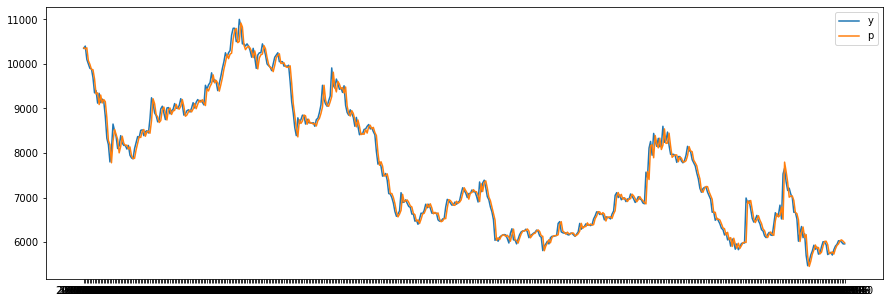

In [116]:
plt.figure(figsize=(15, 5))
plt.plot(y, label='y')
plt.plot(model.predict(x), label='p')
                    plt.legend()

In [117]:
df.head()

,종가,시가,고가,저가,거래량
날짜,,,,,
2017.08.24,10200.0,10050.0,10200.0,10050.0,17484.0
2017.08.25,10600.0,10200.0,10700.0,10200.0,77514.0
2017.08.28,10500.0,10800.0,10800.0,10450.0,26052.0
2017.08.29,10300.0,10400.0,10500.0,10150.0,41579.0
2017.08.30,10400.0,10300.0,10500.0,10200.0,16444.0


# RNN

- 입력 X : x1, x2, x3, x4, x5, x6 (종가, 시가, 고가, 저가, 거래량, 전일비)
- 5일치 X(t=5) : X_t : X_1, X_2, X_3, X_4, X_5
                 X_1 (x1, x2, x3, x4, x5, x6 )
                 X_2 (x1, x2, x3, x4, x5, x6 )
                 ...
  => 5, 6 : 5 시간, 6 특성               

x :  5일치 데이터
y :  다음에 올 하루치 데이터
=> (100 row시) x, y 95set

In [130]:
df_con.head()

,종가,시가,고가,저가,거래량,종가r,시가r,고가r,저가r,거래량r
날짜,,,,,,,,,,
2017.08.30,10400.0,10300.0,10500.0,10200.0,16444.0,10400.0,10350.0,10540.0,10210.0,35814.6
2017.08.31,10350.0,10250.0,10400.0,10250.0,8773.0,10430.0,10390.0,10580.0,10250.0,34072.4
2017.09.01,10400.0,10300.0,10450.0,10200.0,22843.0,10390.0,10410.0,10530.0,10250.0,23138.2
2017.09.04,10100.0,10150.0,10200.0,10000.0,42977.0,10310.0,10280.0,10410.0,10160.0,26523.2
2017.09.05,10000.0,10050.0,10150.0,10000.0,38543.0,10250.0,10210.0,10340.0,10130.0,25916.0


In [126]:
df_con.tail()

,종가,시가,고가,저가,거래량,종가r,시가r,고가r,저가r,거래량r
날짜,,,,,,,,,,
2019.09.04,6030.0,5970.0,6070.0,5900.0,43156.0,5886.0,5858.0,5958.0,5804.0,41344.0
2019.09.05,6030.0,6030.0,6100.0,5990.0,30228.0,5950.0,5896.0,6010.0,5860.0,41823.6
2019.09.06,6000.0,6090.0,6090.0,5990.0,22472.0,5984.0,5964.0,6056.0,5910.0,38094.0
2019.09.09,5960.0,6000.0,6130.0,5960.0,22724.0,5994.0,5998.0,6078.0,5938.0,31115.4
2019.09.10,5960.0,6060.0,6060.0,5860.0,16381.0,5996.0,6030.0,6090.0,5940.0,26992.2


In [120]:
df_con.shape

(496, 10)

In [121]:
df_con.isna().sum()

종가      0
시가      0
고가      0
저가      0
거래량     0
종가r     0
시가r     0
고가r     0
저가r     0
거래량r    0
dtype: int64

In [129]:
x_list=[]
y_list=[]
for i in range(len(df_con) - 5):
    x = df_con.iloc[i: i+5] # 5는 포함을 안한다
    y = df_con.iloc[i+5]['종가']
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(491, 491)

In [148]:
X = np.stack(x_list, 0).astype(np.float32)
y = np.stack(y_list, 0).astype(np.float32).reshape([-1, 1])
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (491, 5, 10), (491, 1), dtype('float32'), dtype('float32'))

In [149]:
np.max(X), np.max(y)

(6932094.0, 11000.0)

In [159]:
# 정규화 (3d -> 2d -> 3d)
X_2d = X.reshape([-1, 10])
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y)
xn = xn.reshape([491, 5, -11])
xn.shape, np.min(xn), np.max(xn), np.min(yn), np.max(yn)


((491, 5, 10), 0.0, 1.0000001, 0.0, 1.0)

In [161]:
tf.reset_default_graph()
cell = tf.nn.rnn_cell.BasicRNNCell(10)

In [187]:
#tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
tf.nn.dynamic_rnn(cell, xn, dtype=tf.float32)

(<tf.Tensor 'rnn_1/transpose_1:0' shape=(491, 5, 100) dtype=float32>,
 LSTMStateTuple(c=<tf.Tensor 'rnn_1/while/Exit_3:0' shape=(491, 100) dtype=float32>, h=<tf.Tensor 'rnn_1/while/Exit_4:0' shape=(491, 100) dtype=float32>))

In [188]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()

cell = tf.nn.rnn_cell.BasicRNNCell(100)
# cell = tf.nn.rnn_cell.BasicGRUCell(100) # LSTM보다 약간 빠르고 약간 성능은 떨어짐
#cell = tf.nn.rnn_cell. #(100) # 장기 단기 텀 메모리 : 가장 복잡하고 성능이 좋음

outputs, last_state = tf.nn.dynamic_rnn(cell, xn, dtype=tf.float32)
# last_state = last_state[1] #BasicLSTMCell

h = slim.fully_connected(last_state, 1) # W와 b가 자동으로 생성되서 행렬곱셈합니다.
cost = tf.reduce_mean((yn-h)**2)
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(100000):
    _, c, = sess.run([train, cost])
    if(i%1000)==0: print(i, c, r2_score(yn, sess.run(h)))
print(i, c, r2_score(yn, sess.run(h)))

0 0.21930918 -2.4402429075224834
1000 0.21930918 -2.4402429075224834
2000 0.21930918 -2.4402429075224834
3000 0.21930918 -2.4402429075224834
4000 0.21930918 -2.4402429075224834
5000 0.21930918 -2.4402429075224834
6000 0.21930918 -2.4402429075224834
7000 0.21930918 -2.4402429075224834
8000 0.21930918 -2.4402429075224834
9000 0.21930918 -2.4402429075224834
10000 0.21930918 -2.4402429075224834
11000 0.21930918 -2.4402429075224834
12000 0.21930918 -2.4402429075224834
13000 0.21930918 -2.4402429075224834
14000 0.21930918 -2.4402429075224834
15000 0.21930918 -2.4402429075224834
16000 0.21930918 -2.4402429075224834
17000 0.21930918 -2.4402429075224834
18000 0.21930918 -2.4402429075224834
19000 0.21930918 -2.4402429075224834
20000 0.21930918 -2.4402429075224834
21000 0.21930918 -2.4402429075224834
22000 0.21930918 -2.4402429075224834
23000 0.21930918 -2.4402429075224834
24000 0.21930918 -2.4402429075224834
25000 0.21930918 -2.4402429075224834
26000 0.21930918 -2.4402429075224834
27000 0.219309

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(h)), label='p')
plt.legend()